# TP3 :  Discrétisation de l'équation de la chaleur

In [1]:
import numpy as np
import math

import scipy.sparse as sparse
import scipy.sparse.linalg

from scipy.integrate import quad

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

### Equation de la chaleur :
On se place dans le domaine temporel $]0,T[$ ($T>0$) et spatial $]0,1[$.
On souhaite discrétiser l'équation de la chaleur avec des conditions aux limites de Dirichlet homogènes :
$$\dfrac{\partial u}{\partial t} - \dfrac{\partial^2 u}{\partial x^2} = f \text{ dans } ]0,T[ \times ]0,1[,$$
$$u(t,0) = u(t,1) = 0 \text{ pour } t \in ]0,T[,$$
$$u(0,x) = u_0(x) \text{ pour } x \in ]0,1[,$$
où $f$ est une fonction de $]0,T[ \times ]0,1[$ donnée et $u_0$ est une fonction donnée de $]0,1[$.

### Discrétisation du domaine :
On discrétise le domaine spatial $]X_{\text{min}},X_{\text{max}}[$ par $M>0$ sous-intervalles (dans la suite $X_{\text{min}}=0$ et $X_{\text{max}}=1$). 
Les points correspondant à cette discrétisation sont les $x_i = X_{\text{min}} + i h_x$ avec $h_x = \frac{X_{\text{max}} - X_{\text{min}}}{M}$ ($0 \leq i \leq M$). 
On discrétise le domaine temporel $]0,T[$ par $N>0$ sous-intervalles.
Les points correspondants sont les $t_n = n h_t$ avec $h_t = \frac{T}{N}$.
On pourra calculer ces points avec les commandes suivantes :

In [2]:
M=2
print(np.linspace(0,1,M+1))

T=2
N=2
print(np.linspace(0,T,N+1))

[0.  0.5 1. ]
[0. 1. 2.]


### Solution exacte :

Pour étudier la convergence de nos schémas numériques, on propose la solution suivante :
$$u(t,x) = \cos(t)\sin(\pi x) . $$

La fonction second membre correspondante est
$$f(t,x) = (\pi^2 \cos(t)-\sin(t)) \sin(\pi x) ,$$
et la donnée initiale est
$$ u_0(x) = \sin(\pi x) . $$

In [3]:
M_PI = math.pi

# sol exacte
def u_ex(t,x):
    return math.cos(t)*math.sin(M_PI * x)

# fonction second membre
def f(t,x):
    return (M_PI**2 * math.cos(t) - math.sin(t)) * math.sin(M_PI * x)

# donnée initiale
def u_0(x):
    return math.sin(M_PI*x)


### Schéma explicite centré :
On se propose d'approcher les dérivées partielles par
$$ \dfrac{\partial u}{\partial t} (t_n,x_j) = \dfrac{u(t_{n+1},x_j) - u(t_n,x_j)}{h_t} + O(h_t),$$
$$ \dfrac{\partial^2 u}{\partial x^2} (t_n,x_j) = \dfrac{u(t_n,x_{j+1}) - 2 u(t_n,x_j) + u(t_n,x_{j-1})}{h_x^2} + O(h_x^2).$$

Ceci nous donne le schéma aux différences finies suivant :
$$ \left\{ \begin{array}{l}
 u_{j}^{n+1} = u_j^n + \dfrac{h_t}{h_x^2} (u_{j-1}^n - 2 u_j^n + u_{j+1}^n) + h_t f(t_n,x_j) 
 \text{  pour  } 1 \leq j \leq M-1 \text{  et  } 0 \leq n \leq N-1 ,
 \\
 u_0^n = u_M^n = 0 \text{  pour  } 0 \leq n \leq N ,
 \\
 u_j^0 = u_0(x_j) \text{  pour  } 0 \leq j \leq M .
 \end{array} \right.$$

In [4]:
# schema explicite centre
def schema_exp_cen(N,M):
    # discretisation du domaine
    X = np.linspace(0,1,M+1)
    
    # donnee initiale
    u = np.zeros((N+1,M+1))
    for j in range(1,M):
        u[0,j] = u_0(X[j])
    
    # cfl
    ht = T/N
    hx = 1/M
    cfl = 2*ht/(hx**2)
    
    # boucle en temps
    for n in range(N):
        for j in range(1,M):
            u[n+1,j] = u[n,j] + 0.5*cfl * (u[n,j-1] - 2*u[n,j] + u[n,j+1]) + ht * f(n*ht,X[j])
    
    # on renvoie la sol
    return u

### Représentation de la solution
Tracer la solution au temps final obtenue numériquement et la comparer avec la solution exacte.
Vérifier que ce schéma n'est stable que sous la condition de CFL
$$ 2 h_t \leq h_x^2 .$$
On pourra faire varier le nombre de CFL $\frac{2 h_t}{h_x^2}$ et vérifier que ce nombre doit être inférieur à 1 pour assurer la stabilité du schéma.


CFL =  0.4999999999999999


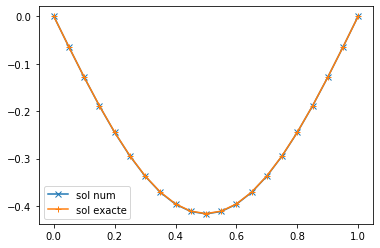

In [5]:
CFL_cible = 0.5
M = 20
hx = 1./M
N = math.ceil(T/(CFL_cible*0.5*hx**2))
ht = T/N
CFL = 2*ht/hx**2
print("CFL = ", CFL)

# solution numerique
u = schema_exp_cen(N,M)
Y = u[N,:]
X = np.linspace(0,1,M+1)
plt.plot(X,Y,marker='x',label="sol num")

# solution exacte
Yex = np.zeros((M+1))
for j in range(1,M):
    Yex[j] = u_ex(T,X[j])
plt.plot(X,Yex,marker='+',label="sol exacte")

plt.legend()
plt.show()

### Schéma implicite centré
Prendre des $M$ modérés ($M=20$ par exemple) et observer que le coût augmente rapidement en augmentant $M$ (essayer $M=50$ ou $M=80$).
En fait, cette condition de CFL est très restrictive.
C'est pour cela qu'en pratique on préfère utiliser des schémas implicites pour l'équation de la chaleur.

On se propose donc d'utiliser le schéma suivant:
$$ \left\{ \begin{array}{l}
 u_{j}^{n+1} = u_j^n + \dfrac{h_t}{h_x^2} (u_{j-1}^{n+1} - 2 u_j^{n+1} + u_{j+1}^{n+1}) + h_t f(t_{n+1},x_j) 
 \text{  pour  } 1 \leq j \leq M-1 \text{  et  } 0 \leq n \leq N-1 ,
 \\
 u_0^n = u_M^n = 0 \text{  pour  } 0 \leq n \leq N ,
 \\
 u_j^0 = u_0(x_j) \text{  pour  } 0 \leq j \leq M .
 \end{array} \right.$$

On peut montrer que la solution de ce schéma implicite peut être calculée en résolvant à chaque pas de temps le système linéaire
$$A U^{n+1} = U^n + h_t F^{n+1}$$
avec
$$ U^n = \begin{pmatrix} u_1^n \\ u_2^n \\ \vdots \\ u_{M-1}^n \end{pmatrix} ,
\qquad
F^{n+1} = \begin{pmatrix} f(t_{n+1},x_{1}) \\ f(t_{n+1},x_2) \\ \vdots \\ f(t_{n+1},x_{M-1}) \end{pmatrix}
\qquad \text{ et } \qquad
A = \begin{pmatrix} 
1 + 2 \alpha & -\alpha &  & (0)
\\
-\alpha & \ddots & \ddots& 
\\
 & \ddots & \ddots & -\alpha
\\
 (0)&  & -\alpha & 1 + 2 \alpha
\end{pmatrix} \quad \text{pour} \quad \alpha = \frac{h_t}{h_x^2}$$

La solution est donc calculée en résolvant ce système linéaire pour obtenir les valeurs aux points intérieurs et on complète avec les conditions de Dirichlet $u_0^{n+1} = u_M^{n+1} =0$.

Coder une fonction retournant la matrice A

In [6]:
# coder la matrice A (sous forme d'une matrice creuse)
def mat_A(N,M):
    ht = T/N
    hx = 1./M
    alpha = ht/hx**2
    
    row = list()
    col = list()
    data = list()
    # premiere ligne
    # A_0,0
    row.append((0))
    col.append((0))
    data.append(1+2*alpha)
    # A_0,1
    row.append((0))
    col.append((1))
    data.append(-alpha)

    for i in range(1,M-2):
        # A_i,i = qque chose (exemple)
        row.append((i))
        col.append((i))
        data.append( 1+2*alpha )  
    
        # A_i,i-1 = autre chose (exemple)
        row.append((i))
        col.append((i-1))
        data.append( -alpha )
    
        # A_i,i+1 = encore autre chose
        row.append((i))
        col.append((i+1))
        data.append( -alpha )

    # derniere ligne
    row.append((M-2))
    col.append((M-2))
    data.append(1+2*alpha)
    
    row.append((M-2))
    col.append((M-3))
    data.append((-alpha))
        
    # assemblage final
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)      
    A = (sparse.coo_matrix((data, (row, col)), shape=(M-1, M-1))).tocsr()
    return A

Coder une fonction retournant la solution générée par le schéma implicite

In [7]:
# fonction calculant la solution obtenue par le schema implicite
def schema_imp_cen(N,M):
    # discretisation du domaine
    X = np.linspace(0,1,M+1)
    
    # donnee initiale
    u = np.zeros((N+1,M+1))
    for j in range(1,M):
        u[0,j] = u_0(X[j])
    
    # pas de temps
    ht = T/N
    
    # matrice A
    A = mat_A(N,M)
    
    # boucle en temps
    for n in range(N):
        # a chaque pas de temps, on resout le systeme lineaire
        # calcul du second membre
        RHS = np.zeros((M-1))
        for i in range(M-1):
            RHS[i] = u[n,i+1] + ht*f((n+1)*ht , X[i+1])
        # resolution du systeme
        sol_lin = sparse.linalg.spsolve(A, RHS)
        # mise a jour de la solution globale
        u[n+1, 1:M] = sol_lin
    
    # on renvoie la sol
    return u


Représenter graphiquement la solution au temps final obtenue à partir du schéma implicite et la comparer à la solution exacte. On observera que le schéma est stable (sans condition de CFL) et qu'on peut rafiner en espace sans que ce soit trop coûteux.

CFL =  319.99999999999994


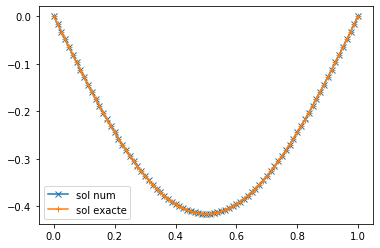

In [8]:
N = 80
M = 80
hx = 1./M
ht = T/N
CFL = 2*ht/hx**2
print("CFL = ", CFL)

# solution numerique
u = schema_imp_cen(N,M)
Y = u[N,:]
X = np.linspace(0,1,M+1)
plt.plot(X,Y,marker='x',label="sol num")

# solution exacte
Yex = np.zeros((M+1))
for j in range(1,M):
    Yex[j] = u_ex(T,X[j])
plt.plot(X,Yex,marker='+',label="sol exacte")

plt.legend()
plt.show()


### Vidéo récapitulative
La vidéo suivante permet de comparer le comportement au cours du temps des solutions des deux schémas.
Cette fonction est longue à faire tourner (c'est normal).
Observer le comportement si le nombre de CFL est plus grand que 1.

CFL =  1.0989010989010988


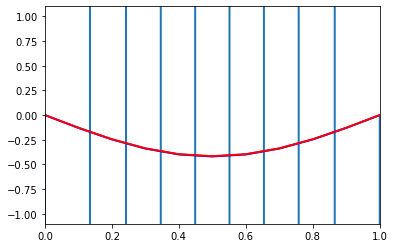

In [9]:
CFL_cible = 1.1
M = 10
hx = 1./M
N = math.ceil(T/(CFL_cible*0.5*hx**2))
ht = T/N
CFL = 2*ht/hx**2
print("CFL = ", CFL)


X = np.linspace(0,1,M+1)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

# on garde les bornes pour afficher les solutions
u_ec = schema_exp_cen(N,M)
u_ic = schema_imp_cen(N,M)
u_min = min(u_ec[0,:])
u_max = max(u_ec[0,:])
Y_min = -u_max - 0.1*(u_max-u_min)
Y_max = u_max + 0.1*(u_max-u_min)    

ax.set_xlim(( 0, 1))
ax.set_ylim((Y_min, Y_max))

line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2, color='b')
line3, = ax.plot([], [], lw=2, color='r')

def init():
    line.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return (line,line2, line3)
def animate(nt):
    # schema explicite centre
    line.set_data(X, u_ec[nt,:])
    
    # schema implicite centre
    line2.set_data(X, u_ic[nt,:])
    
    # solution exacte
    dt = T/N
    sol_ex = np.zeros(M+1)
    for i in range(0,M+1):
        sol_ex[i] = u_ex(nt*dt,X[i])
    line3.set_data(X, sol_ex)
    return (line,line2, line3)

# call the animator. 
# interval: Delay between frames in milliseconds. Defaults to 200.
# blit=True means only re-draw the parts that have changed.
# see https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N+1, interval=20, blit=True)
HTML(anim.to_html5_video())